# NFL Train Detection Model
This is the training notebook for my EffDet detection model. The code is very messy sorry.

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
VER = 31
DD = 4
SIZE = 1280

In [7]:
if 1:
    #os.system('pip install ../input/nfl-lib/timm-0.1.26-py3-none-any.whl')
    #os.system('tar xfz ../input/nfl-lib/pkgs.tgz')
    # for pytorch1.6
    cmd = "sed -i -e 's/ \/ / \/\/ /' ../dec-16-20/timm-efficientdet-pytorch/effdet/bench.py"
    os.system(f'{cmd}')


# In[2]:


import sys
sys.path.insert(0, "../dec-16-20/pip/timm-efficientdet-pytorch")
sys.path.insert(0, "../dec-16-20/pip/omegaconf")
sys.path.insert(0, "../dec-19-20")

import torch
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
from effdet.efficientdet import HeadNet
from tqdm import tqdm
from myutils import competition_metric, best_f1, post_process, camera_selection
import shutil

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
#os.environ["CUDA_VISIBLE_DEVICES"]= ','.join([str(i) for i in range(1,2)])

print('\nList of GPUs:')
print(torch.cuda.device_count())

SEED = 42
POSTPROCESS = True

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(SEED)


List of GPUs:
1


In [8]:
BASE = '/raid/Kaggle/NFL/'

In [9]:
true = pd.read_csv('../dec-26-20/valid_0_fold.csv')
print (true.shape)

video_test = ['57586_000540_Endzone.mp4', '57586_000540_Sideline.mp4',
       '57586_001934_Endzone.mp4', '57586_001934_Sideline.mp4',
       '57586_004152_Endzone.mp4', '57586_004152_Sideline.mp4']
test_plays = true.loc[true.video.isin(video_test)][['gameKey','playID']].drop_duplicates().astype('int')

video_valid = ['58106_002918_Endzone.mp4', '58106_002918_Sideline.mp4',
       '57778_004244_Endzone.mp4', '57778_004244_Sideline.mp4',
       '57781_000252_Endzone.mp4', '57781_000252_Sideline.mp4',
       '57783_003374_Endzone.mp4', '57783_003374_Sideline.mp4',
       '57784_001741_Endzone.mp4', '57784_001741_Sideline.mp4',
       '57910_001164_Endzone.mp4', '57910_001164_Sideline.mp4',
       '58000_001306_Endzone.mp4', '58000_001306_Sideline.mp4',
       '58098_001193_Endzone.mp4', '58098_001193_Sideline.mp4',
       '58107_004362_Endzone.mp4', '58107_004362_Sideline.mp4']
valid_plays = true.loc[true.video.isin(video_valid)][['gameKey','playID']].drop_duplicates().astype('int')

(39640, 18)


In [10]:
# # Data Preparation

# In[3]:
video_labels = pd.read_csv(BASE+'train_labels.csv').fillna(0)
video_labels['image_name'] = video_labels['video'].str.replace('.mp4', '') + '_' + video_labels['frame'].astype(str) + '.png'

#video_test = os.listdir(BASE+'/test')
#test_plays = pd.DataFrame([x.split('_')[:2] for x in video_test], columns=['gameKey', 'playID']).drop_duplicates().astype(int)
images_test = video_labels[ video_labels.video.isin(video_test)].image_name.unique()


plays = video_labels[['gameKey', 'playID']].drop_duplicates().merge(test_plays, indicator=True, how='outer')

#valid_plays = plays.query('_merge != "both"').sample(n=9, random_state=123).drop(columns='_merge')
valid_plays = pd.concat((test_plays, valid_plays))

video_valid = video_labels.merge(valid_plays, how='right')['video'].unique()


# In[4]:

video_labels['x'] = video_labels['left']
video_labels['y'] = video_labels['top']
video_labels['w'] = video_labels['width']
video_labels['h'] = video_labels['height']

video_labels_with_impact = video_labels[~video_labels.video.isin(video_valid) & video_labels['impact'] > 0]
'''
for row in tqdm(video_labels_with_impact[['video','frame','label']].values):
    frames = np.array([-4,-3,-2,-1,1,2,3,4])+row[1]
    video_labels.loc[(video_labels['video'] == row[0]) 
                                 & (video_labels['frame'].isin(frames))
                                 & (video_labels['label'] == row[2]), 'impact'] = 1
 
video_labels = video_labels[video_labels.groupby('image_name')['impact'].transform("sum") > 0].reset_index(drop=True)

video_labels['impact'] += 1
video_labels['impact'].value_counts()
'''

'\nfor row in tqdm(video_labels_with_impact[[\'video\',\'frame\',\'label\']].values):\n    frames = np.array([-4,-3,-2,-1,1,2,3,4])+row[1]\n    video_labels.loc[(video_labels[\'video\'] == row[0]) \n                                 & (video_labels[\'frame\'].isin(frames))\n                                 & (video_labels[\'label\'] == row[2]), \'impact\'] = 1\n \nvideo_labels = video_labels[video_labels.groupby(\'image_name\')[\'impact\'].transform("sum") > 0].reset_index(drop=True)\n\nvideo_labels[\'impact\'] += 1\nvideo_labels[\'impact\'].value_counts()\n'

In [11]:
#video_labels.to_csv('video_labels.csv',index=False)
video_labels = pd.read_csv('../dec-18-20/video_labels.csv')

In [12]:
test_labels = video_labels[video_labels['video'].isin(video_test) & (video_labels['impact'] == 2)].copy()

images_valid = video_labels[ video_labels.video.isin(video_valid)].image_name.unique()
images_train = video_labels[~video_labels.video.isin(video_valid)].image_name.unique()

In [13]:
r = 1.0
video_labels.x -= video_labels.w * r/2
video_labels.y -= video_labels.h * r/2
video_labels.w *= 1+r
video_labels.h *= 1+r

video_labels.x = np.clip(video_labels.x,0,None).astype('int32')
video_labels.y = np.clip(video_labels.y,0,None).astype('int32')
video_labels.w = np.clip(video_labels.w,0,1280-video_labels.x).astype('int32')
video_labels.h = np.clip(video_labels.h,0,720-video_labels.y).astype('int32')

In [14]:
def mk_images(video_name, video_labels, video_dir, out_dir, only_with_impact=True):
    video_path=f"{video_dir}/{video_name}"
    video_name = os.path.basename(video_path)
    vidcap = cv2.VideoCapture(video_path)
    frame = 0
    while True:
        it_worked, img = vidcap.read()
        if not it_worked:
            break
        frame += 1
        if only_with_impact:
            boxes = video_labels.query("video == @video_name and frame == @frame")
            boxes_with_impact = boxes[boxes.impact > 1.0]
            if boxes_with_impact.shape[0] == 0:
                continue
        image_path = f'{out_dir}/{video_name}'.replace('.mp4',f'_{frame}.png')
        _ = cv2.imwrite(image_path, img)

In [15]:
uniq_video = video_labels.video.unique()
video_dir = '/raid/Kaggle/NFL/train'
out_dir = '../dec-16-20/train_images'
if not os.path.isdir(out_dir):
    os.system(f'mkdir -p {out_dir}')
    for video_name in tqdm(uniq_video):
        mk_images(video_name, video_labels, video_dir, out_dir, False)

In [16]:
def get_train_transforms():
    return A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.Resize(height=SIZE, width=SIZE, p=1),
            A.ShiftScaleRotate(rotate_limit=12,scale_limit=0,shift_limit=0,border_mode=0,value=0,p=0.5),
            A.ShiftScaleRotate(rotate_limit=0, scale_limit=0., shift_limit=0.12, border_mode=0, value=0, p=0.5),
            A.Blur(blur_limit=12, always_apply=False, p=0.1),
            A.ChannelDropout (channel_drop_range=(1, 1), fill_value=0.2, always_apply=False, p=0.05),
            A.ColorJitter (brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.25),
            A.MotionBlur(blur_limit=48,p=0.1),
            A.RandomFog (fog_coef_lower=0.15, fog_coef_upper=0.25, alpha_coef=0.3, always_apply=False, p=0.1),
            #A.RandomGamma (gamma_limit=(80, 120), eps=None, always_apply=False, p=0.1),
            A.RandomRain (slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(200, 200, 200), blur_value=7, 
                        brightness_coefficient=0.7, rain_type=None, always_apply=False, p=0.1),
            A.RandomShadow (shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, 
                          shadow_dimension=5, always_apply=False, p=0.05),
            A.RandomSnow (snow_point_lower=0.1, snow_point_upper=0.3, brightness_coeff=1.5, always_apply=False, p=0.05),
            A.RandomSunFlare (flare_roi=(0, 0, 1, 0.5), angle_lower=0, angle_upper=1, num_flare_circles_lower=6, 
                            num_flare_circles_upper=10, src_radius=400, src_color=(255, 255, 255), always_apply=False, p=0.05),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=SIZE, width=SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_test_transforms():
    return A.Compose([
            A.Resize(height=SIZE, width=SIZE, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)

In [17]:
TRAIN_ROOT_PATH = out_dir

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image, boxes, labels = self.load_image_and_boxes(index)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = torch.tensor(labels)
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        #print(f'{TRAIN_ROOT_PATH}/{image_id}')
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}', cv2.IMREAD_COLOR).copy().astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_name'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        labels = records['impact'].values
        return image, boxes, labels

class TestDatasetRetriever(Dataset):
    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}', cv2.IMREAD_COLOR).copy().astype(np.float32)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [18]:
train_dataset = DatasetRetriever(
    image_ids=images_train,
    marking=video_labels,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=images_valid,
    marking=video_labels,
    transforms=get_valid_transforms(),
    test=True,
)

test_dataset = TestDatasetRetriever(
    image_ids=images_test,
    transforms=get_test_transforms()
)

# Display Augmentation

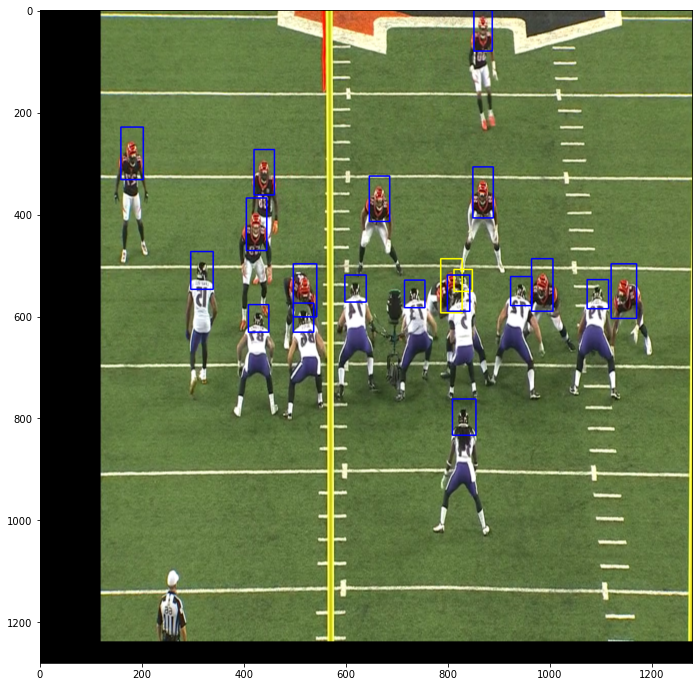

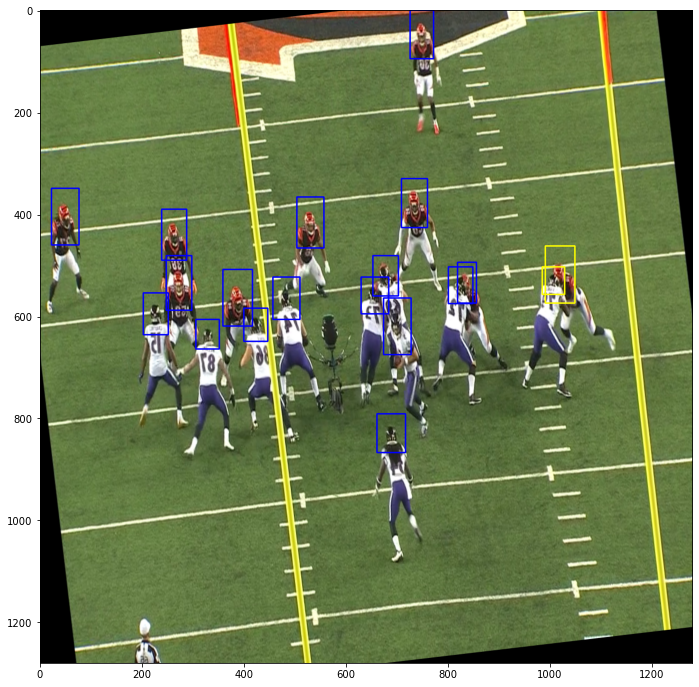

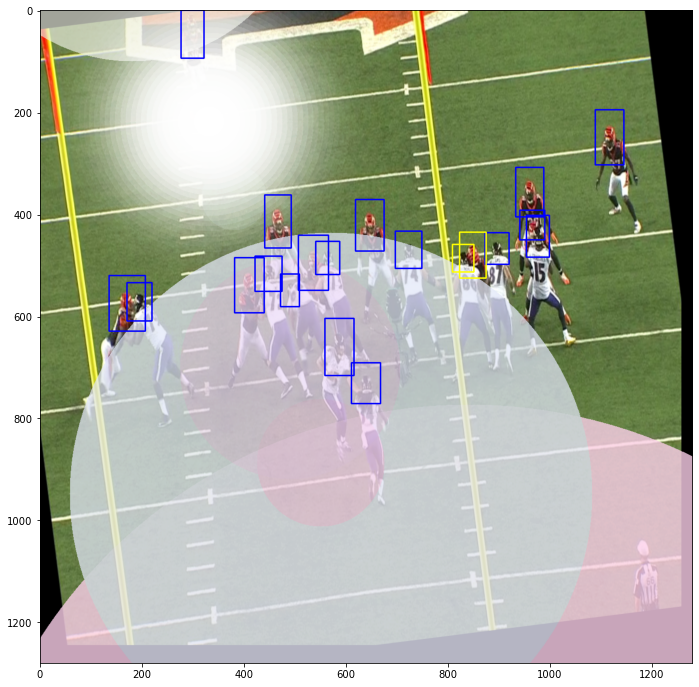

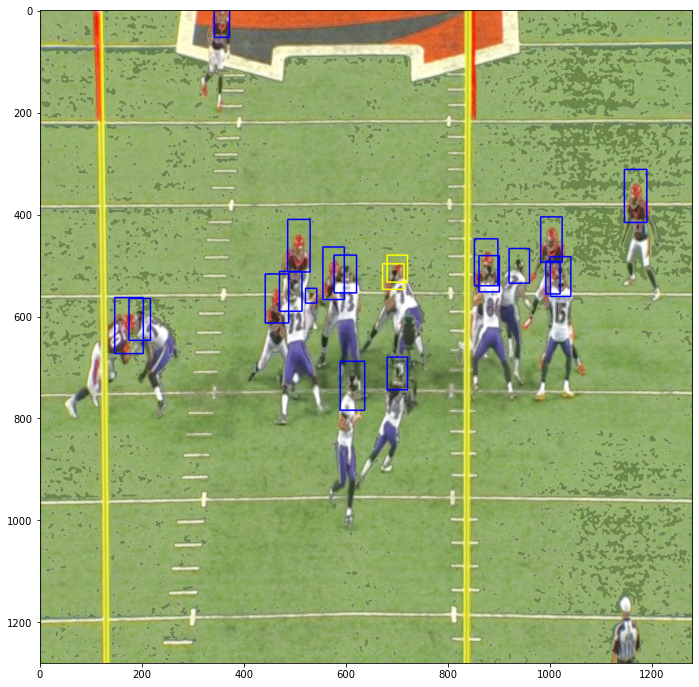

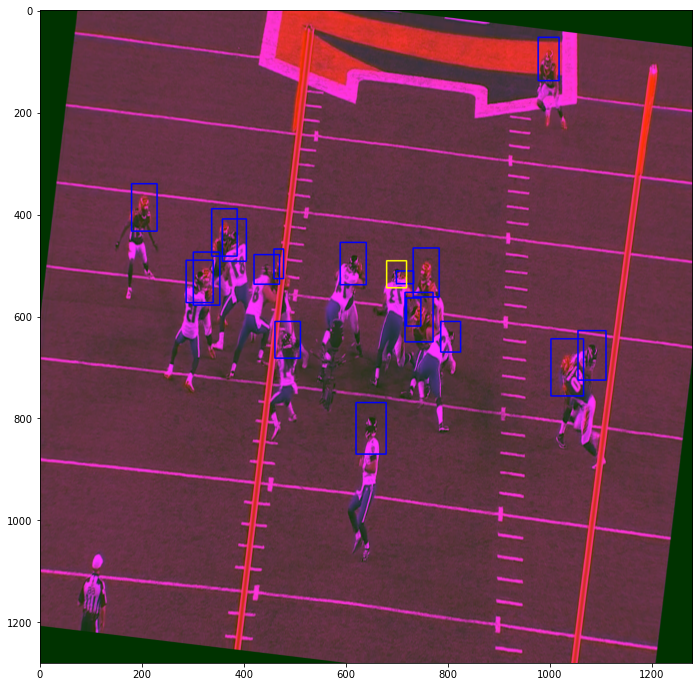

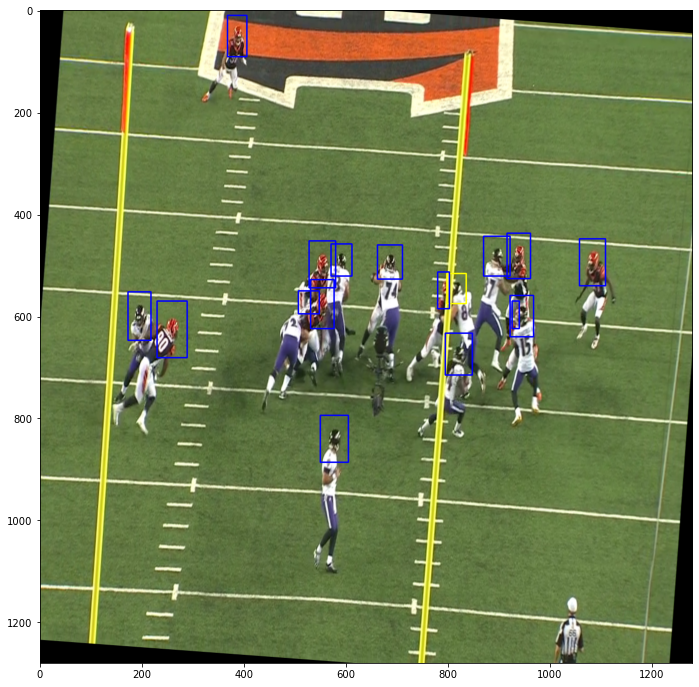

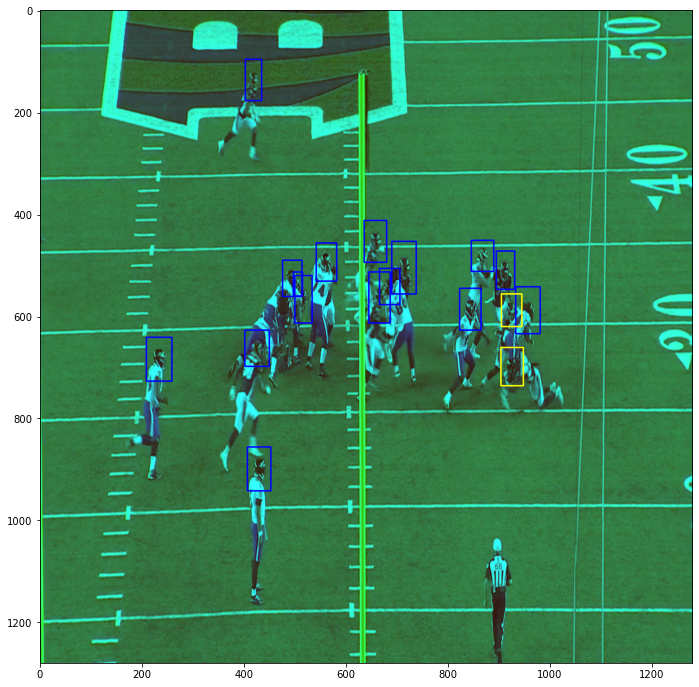

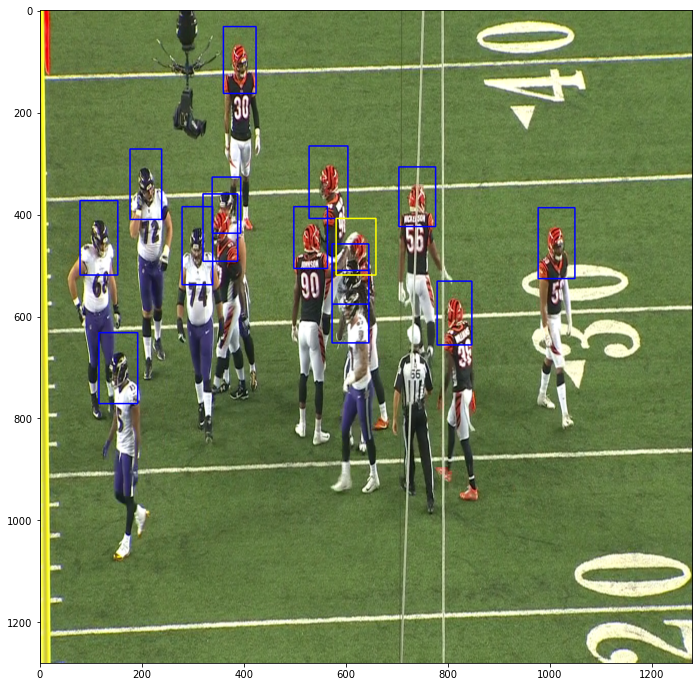

In [19]:
train_gen = DatasetRetriever(
    image_ids=images_train,
    marking=video_labels,
    transforms=get_train_transforms(),
    test=False,
)

for j,b in enumerate(train_gen):
    if j%10==1:
        img = b[0].numpy().transpose(1,2,0)
        img = (img*255).astype('uint8')
        lab = b[1]['labels'].numpy()
        boxes = b[1]['boxes'].numpy()
        for i,bx in enumerate(boxes):
            bx = bx.astype('int32')
            cl = (255,255,0) if lab[i]==2 else (0,0,255)
            cv2.rectangle(img,(bx[1],bx[0]),(bx[3],bx[2]),cl,2)
        plt.figure(figsize=(12,12))
        plt.imshow(img)
        plt.show()
    if j>=100: 
        break

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        
        #if os.path.exists(self.base_dir):
        #    shutil.rmtree(self.base_dir)
        
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log_%i.txt'%VER
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader, test_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')
                
            # if e == 0:
            #     self.load('../input/nfl-models/best-checkpoint-002epoch.bin')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)
            
            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint_%i.bin'%VER)

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch_%i.bin'%VER)
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-4]:
                    os.remove(path)
                  
            last_file = f'{self.base_dir}/last-checkpoint_%i.bin'%VER
            last_model = load_net(last_file)
            test_df = validation_preds(last_model, test_loader, e)
            best_f1(test_labels, test_df)
            if POSTPROCESS:
                pp_df = test_df[test_df['scores'] > 0.3].sort_values(['gameKey', 'playID', 'frame']).reset_index(drop=True)
                pp_df = post_process(pp_df)
                pp_df = camera_selection(pp_df)
                print('After PP:')
                best_f1(test_labels, pp_df)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            #if step > 5:
            #    break
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            
            loss, _, _ = self.model(images, boxes, labels)
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [17]:
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 2 
    n_epochs = 30
    lr = 0.00005
    folder = 'effdet-models'
    verbose = True
    verbose_step = 1
    step_scheduler = False
    validation_scheduler = True
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=True, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=1e-8,
        eps=1e-08
    )

In [18]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d%i'%DD)
    net = EfficientDet(config, pretrained_backbone=False)
    config.num_classes = 2
    config.image_size=SIZE
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])
    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

def make_predictions(net, images, score_threshold=0.5):
    images = torch.stack(images).cuda().float()
    box_list = []
    score_list = []
    with torch.no_grad():
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]   
            label = det[i].detach().cpu().numpy()[:,5]
            # using only label = 2
            indexes = np.where((scores > score_threshold) & (label == 2))[0]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            box_list.append(boxes[indexes])
            score_list.append(scores[indexes])
    return box_list, score_list

def validation_preds(model, test_loader, epoch):
    result_image_ids = []
    results_boxes = []
    results_scores = []
    for images, image_ids in test_loader:
        box_list, score_list = make_predictions(model, images, score_threshold=-1)
        for i, image in enumerate(images):
            boxes = box_list[i]
            scores = score_list[i]
            image_id = image_ids[i]
            boxes[:, 0] = (boxes[:, 0] * 1280 / SIZE)
            boxes[:, 1] = (boxes[:, 1] * 720 / SIZE)
            boxes[:, 2] = (boxes[:, 2] * 1280 / SIZE)
            boxes[:, 3] = (boxes[:, 3] * 720 / SIZE)
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            boxes = boxes.astype(np.int32)
            boxes[:, 0] = boxes[:, 0].clip(min=0, max=1280-1)
            boxes[:, 2] = boxes[:, 2].clip(min=0, max=1280-1)
            boxes[:, 1] = boxes[:, 1].clip(min=0, max=720-1)
            boxes[:, 3] = boxes[:, 3].clip(min=0, max=720-1)
            
            # REDUCE BBOX 50% SINCE WE TRAINED WITH 200%
            boxes[:, 2] = boxes[:,2] / 2.
            boxes[:, 3] = boxes[:,3] / 2.
            boxes[:, 0] = boxes[:, 0] + boxes[:, 2] / 2.
            boxes[:, 1] = boxes[:, 1] + boxes[:, 3] / 2.
            
            result_image_ids += [image_id]*len(boxes)
            results_boxes.append(boxes)
            results_scores.append(scores)    
            
    box_df = pd.DataFrame(np.concatenate(results_boxes), columns=['left', 'top', 'width', 'height'])
    test_df = pd.DataFrame({'scores':np.concatenate(results_scores), 'image_name':result_image_ids})
    test_df = pd.concat([test_df, box_df], axis=1)
    test_df['gameKey'] = test_df.image_name.str.split('_').str[0].astype(int)
    test_df['playID'] = test_df.image_name.str.split('_').str[1].astype(int)
    test_df['view'] = test_df.image_name.str.split('_').str[2]
    test_df['frame'] = test_df.image_name.str.split('_').str[3].str.replace('.png','').astype(int)
    test_df['video'] = test_df.image_name.str.rsplit('_',1).str[0] + '.mp4'
    
    #test_df.to_csv(f'test_df_{epoch:02}.csv', index=False)
    return test_df.sort_values(['gameKey', 'playID', 'frame']).reset_index(drop=True)

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    #device = torch.device('cuda:0')
    device = ('cuda' if torch.cuda.is_available() else 'cpu')

    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=16,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        pin_memory=False,
        collate_fn=collate_fn,
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=0,
        drop_last=False,
        collate_fn=collate_fn
    )
    
    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader, test_loader)

In [20]:
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d%i'%DD)
    config.train_scale_min = 1.0
    config.train_scale_max = 8.0
    net = EfficientDet(config, pretrained_backbone=False)
    if DD==5:
        checkpoint = torch.load('../dec-16-20/pip/efficientdet_d5-ef44aea8.pth')
    elif DD==4:
        checkpoint = torch.load('../dec-16-20/pip/tf_efficientdet_d4-5b370b7a.pth')
    elif DD==2:
        checkpoint = torch.load('../dec-16-20/pip/tf_efficientdet_d2-cb4ce77d.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 2
    config.image_size = SIZE
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

In [21]:
run_training()

Fitter prepared. Device is cuda

2020-12-27T17:49:17.216614
LR: 5e-05
[RESULT]: Train. Epoch: 0, summary_loss: 30.10665, time: 2595.03565
[RESULT]: Val. Epoch: 0, summary_loss: 0.99929, time: 152.24913
Best Thr: 0.60
TP: 0, FP: 0, FN: 997, PRECISION: 0.0000, RECALL: 0.0000, F1 SCORE: 0.0
After PP:
Best Thr: 0.60
TP: 0, FP: 0, FN: 997, PRECISION: 0.0000, RECALL: 0.0000, F1 SCORE: 0.0

2020-12-27T18:40:31.629160
LR: 5e-05
[RESULT]: Train. Epoch: 1, summary_loss: 0.61433, time: 2556.79549
[RESULT]: Val. Epoch: 1, summary_loss: 0.40519, time: 147.71121
Best Thr: 0.30
TP: 284, FP: 915, FN: 713, PRECISION: 0.2369, RECALL: 0.2849, F1 SCORE: 0.25865159871371163
After PP:
Best Thr: 0.30
TP: 113, FP: 190, FN: 884, PRECISION: 0.3729, RECALL: 0.1133, F1 SCORE: 0.17384579607529096

2020-12-27T19:31:00.310386
LR: 5e-05
[RESULT]: Train. Epoch: 2, summary_loss: 0.42009, time: 2553.85848
[RESULT]: Val. Epoch: 2, summary_loss: 0.35830, time: 145.58906
Best Thr: 0.31
TP: 384, FP: 649, FN: 613, PRECISION:

KeyboardInterrupt: 